In [ ]:
# %% 
from adaptive_kmpc_py.controller import adaptiveKMPC
from adaptive_kmpc_py.predictor import EDMD 
import dynamics as dyn 
import matplotlib.pyplot as plt
import pykoopman as pk 
import numpy as np 

# load reference trajectory
r = np.loadtxt("trajectories/Xref.txt")
T_ref = np.loadtxt("trajectories/Tref.txt")
  
# build single pendulum
m1 = 0.27                 # link 1 mass 
l1 = 0.4                  # link 1 length 
lc = 0.131                # distance rotational axis to center of mass (COM) of link 1
I1 = 0.007479             # moment of inertia of link 1 expressed in COM frame 
m_dof = 1;                # number of DOF
n = 2
sp = dyn.nPendulum(m1,l1,lc,I1,n,m_dof)

In [ ]:
#%%
# choose basis functions for EDMD
# see https://pykoopman.readthedocs.io/en/master/tutorial_compose_observables.html
# for more information on how to compose observables 
observables = [lambda x1,x2: np.sin(x1), lambda x1,x2: np.cos(x1), lambda x1,x2: x2*np.sin(x1), lambda x1,x2: x2*np.cos(x1)]
observable_names = [
    lambda s,t: f"sin{s}",
    lambda s,t: f"cos{s}",
    lambda s,t: f"{t}*sin{s}",
    lambda s,t: f"{t}*cos{s}",
]
obs = pk.observables.CustomObservables(observables, observable_names=observable_names)


Nb = 500                                                    # length of circular buffer, containing data used for EDMD
edmd = EDMD(sp.n, sp.m_dof, Nb, obs)                        # circular buffer is created within EDMD class    

# Controller parameters
Q = np.concatenate(([1], np.zeros(5)))                      # weights on tracking error (with these weights emphasis is put only on tracking of the joint angle θ1)
Qf = np.concatenate(([1], np.zeros(5)))                     # weights on tracking error, final state
R = np.ones(m_dof) * 1                                      # weights on control effort
H = 30                                                      # prediction horizon
ul = np.array([-6.0])                                       # lower limit on controls
uu = np.array([6.0])                                        # upper limit on controls

ctrl = adaptiveKMPC(edmd, Q, Qf, R, r, H, ul, uu)           # build controller 

In [ ]:
# %%
# Preceding experiment for gathering data 
h = T_ref[2]-T_ref[1]                                       # discretization step length of the reference trajectory determines control freq. 
X_p = np.zeros((sp.n, Nb))                                  
U_p = np.zeros((m_dof, Nb-1))     
T_p = np.linspace(0,h*(Nb-1),Nb)

x0 = np.zeros(2)                                            # initial state 
X_p[:,1] = x0
for i in range(Nb-1):
    U_p[:,i] = 0.15*np.cos(2*np.pi*0.05*(i+1)*h)           
    X_p[:,i+1] = dyn.simulate(X_p[:,i], U_p[:,i], h, sp)

# fill circular buffer 
ctrl.update_buffer(X_p, U_p, T_p)

# Reference tracking 
N = 500                                                     # duration of the tracking process is given by h*(N-1) (when the reference trajectory ends, the controller will track the last state)
X_a = np.zeros((sp.n, N))
U_a = np.zeros((m_dof, N-1))    
T_a = np.linspace(0,h*(N-1),N)

X_a[:,0] = X_p[:,-1]                                                        # assumption: the tracking process starts immediately after preceding experiment 
for i in range(N-1):
    U_a[:,i] = ctrl.get_control(X_a[:,i], i)                                # this function carries out the EDMD, building and solving of the MPC problem. Variable names inside the function are chosen according to the notation in the paper. 
    X_a[:,i+1] = dyn.simulate(X_a[:,i], U_a[:,i], h, sp)                        # apply control 
    ctrl.update_buffer(X_a[:,i+1].reshape((n,1)), U_a[:,i].reshape((m_dof,1)), np.array([T_a[i]]))                        # buffer is updated in every time step to provide new data for the EDMD 

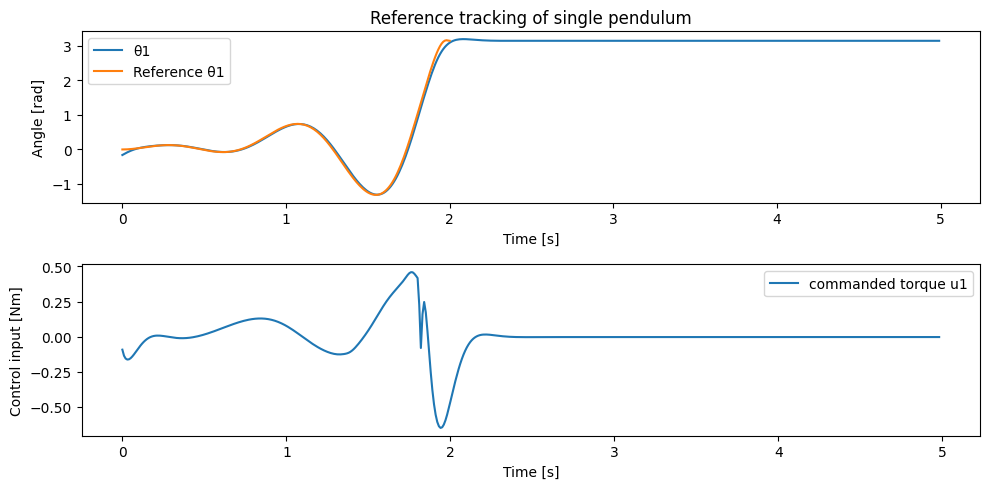

In [ ]:
#%%
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.title("Reference tracking of single pendulum")
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")
plt.subplot(2, 1, 2)
plt.xlabel("Time [s]")
plt.ylabel("Control input [Nm]")
plt.grid()
plt.subplot(2, 1, 1)
plt.plot(T_a[0:], X_a[0,:], label="θ1")
plt.plot(T_ref[0:], r[:,0], label="Reference θ1")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(T_a[0:-1], U_a[0,:], label="commanded torque u1")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()